# **Fitting Data - Basic implementation of Python packages**

In this notebook I show some basic implementation of different Python packages for data fitting. The idea is to learn the different options there are out there so the reader can then study them in more detail if needed.

If for some reason there is a package missing, you will need to manually install it by running `!pip install <package>` in a cell.

In [16]:
!pip install iminuit
!pip install lmfit
!pip install emcee
!pip install corner
!pip install chainconsumer
#!pip install pystan
#!pip install pymc3

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scipy
import lmfit
import emcee
#import stan
#import pystan
import iminuit
from iminuit.util import describe, make_func_code

np.random.seed(32)



# **The data are generated starting from a straight line and then adding modifications**

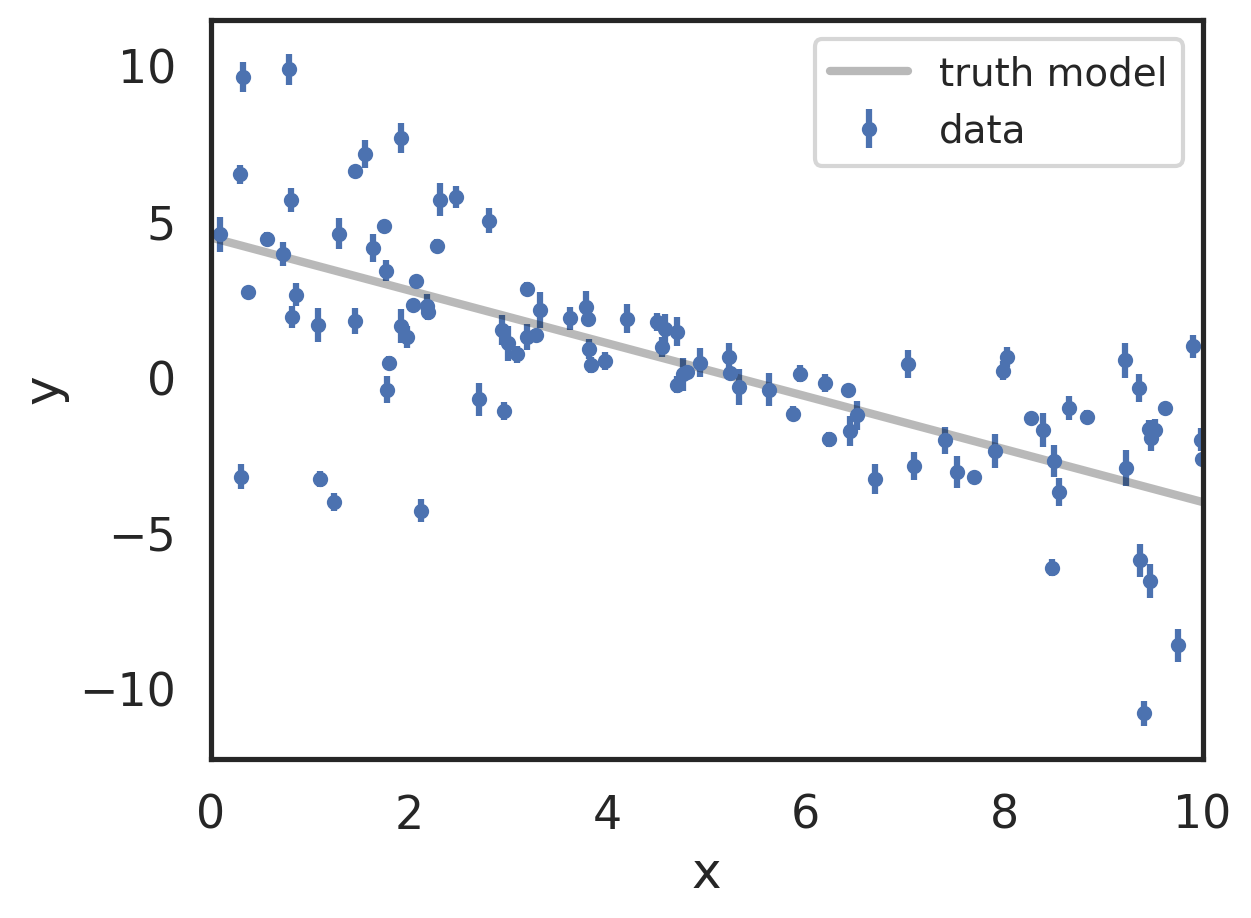

In [18]:
# Choose the "true" parameters.
m_true = -0.85
b_true = 4.5
f_true = 0.9

# Generate some synthetic data from the model.
N = 100
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".b", capsize=0, label="data")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label="truth model")
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14)
plt.show()

## **scipy - minimize**

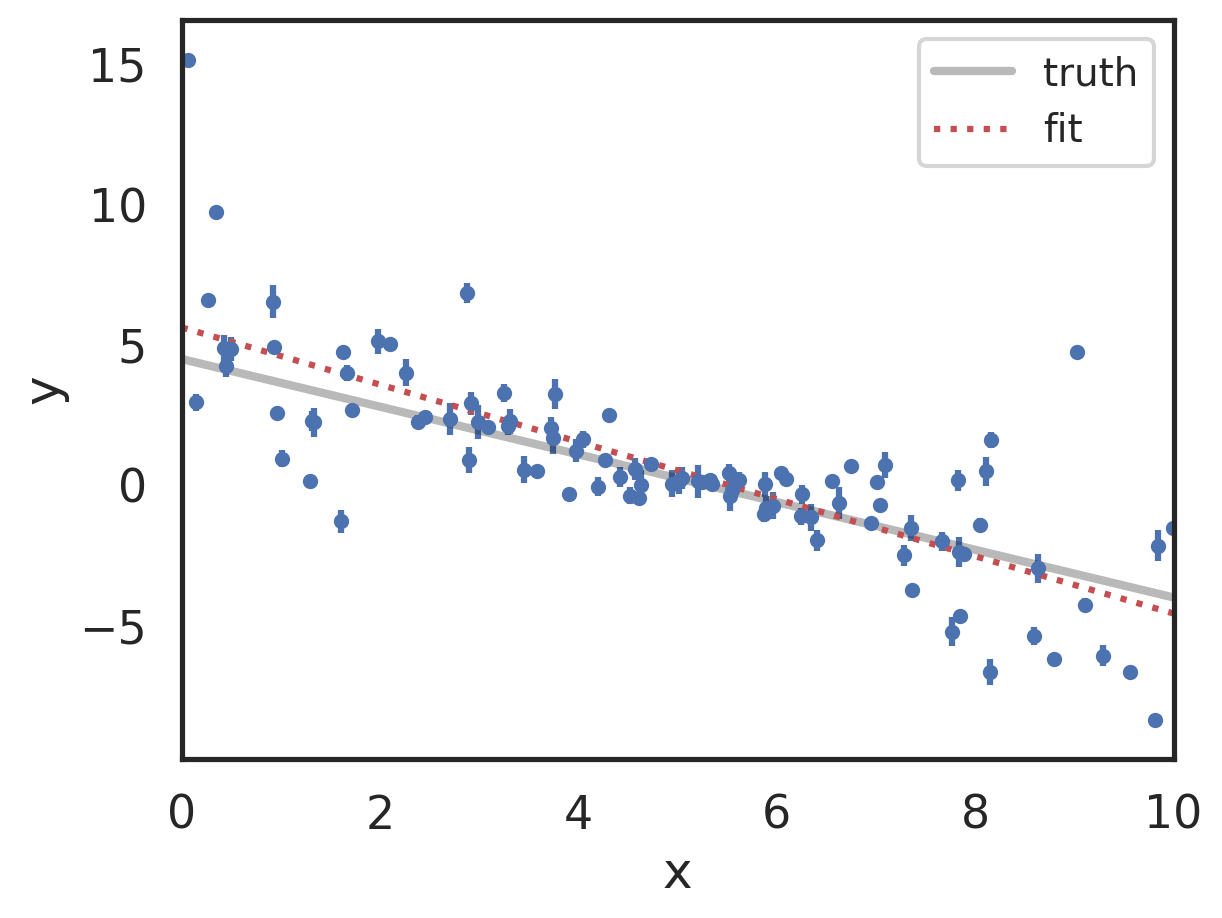

m = -1.0198 (m_true = -0.85)
b = 5.627 (b_true = 4.5)


In [6]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m*x + b
    sigma2 = yerr**2
    return np.sum((y - model)**2 / sigma2)

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
results = scipy.optimize.minimize(log_likelihood, p0, args=(x, y, yerr))

m_pred, b_pred = results.x

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".b", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":r", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


print(f'm = {m_pred:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} (b_true = {b_true})')

m_stimed=[m_pred]
b_stimed=[b_pred]
m_std_max=[0]
m_std_min=[0]
b_std_max=[0]
b_std_min=[0]
method=["scipy optimize"]


## **scipy - curve_fit**

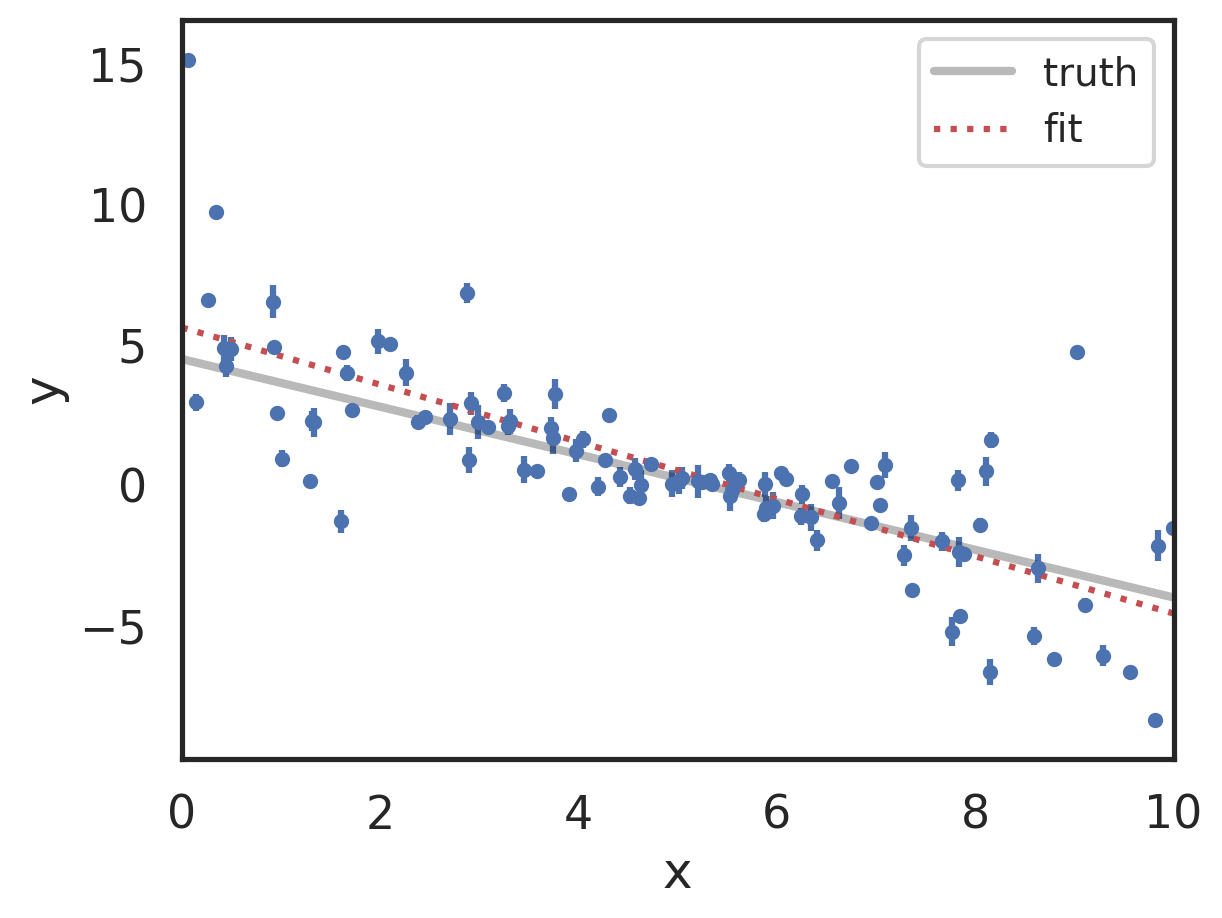

m = -1.0198 +/- 0.0822 (m_true = -0.85)
b = 5.627 +/- 0.463 (b_true = 4.5)


In [7]:
def function(x, m, b):
    model = m*x + b
    return model

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
pfit, pcov = scipy.optimize.curve_fit(function, x, y, p0=p0, sigma=yerr)

m_pred, b_pred = pfit
m_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".b", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":r", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

m_stimed.append(m_pred)
b_stimed.append(b_pred)
m_std_max.append(m_std)
m_std_min.append(m_std)
b_std_max.append(b_std)
b_std_min.append(b_std)
method.append("scipy curve_fit")

## **scipy - leastsq**

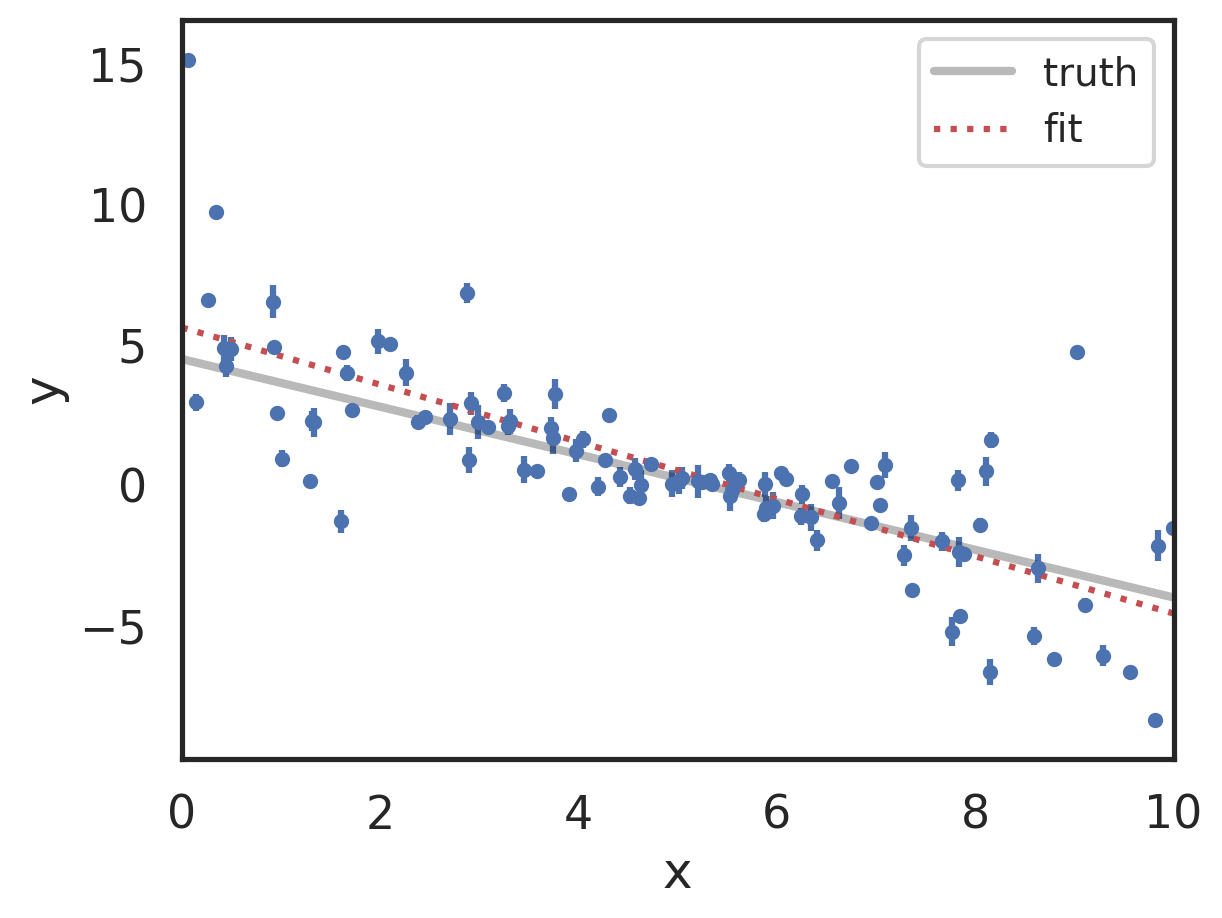

m = -1.0198 +/- 0.0088 (m_true = -0.85)
b = 5.627 +/- 0.050 (b_true = 4.5)


In [8]:
def residual_function(theta, x, y, yerr):
    m, b = theta
    model = m*x + b
    return (model - y)/yerr

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
pfit, pcov, infodict, errmsg, success = scipy.optimize.leastsq(residual_function, p0,
                                                               args=(x, y, yerr),
                                                               full_output=1)

m_pred, b_pred = pfit
try:
    m_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])
except:
    m_std = b_std = np.inf

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".b", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":r", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

m_stimed.append(m_pred)
b_stimed.append(b_pred)
m_std_max.append(m_std)
m_std_min.append(m_std)
b_std_max.append(b_std)
b_std_min.append(b_std)
method.append("scipy leastsq")

## **lmfit**

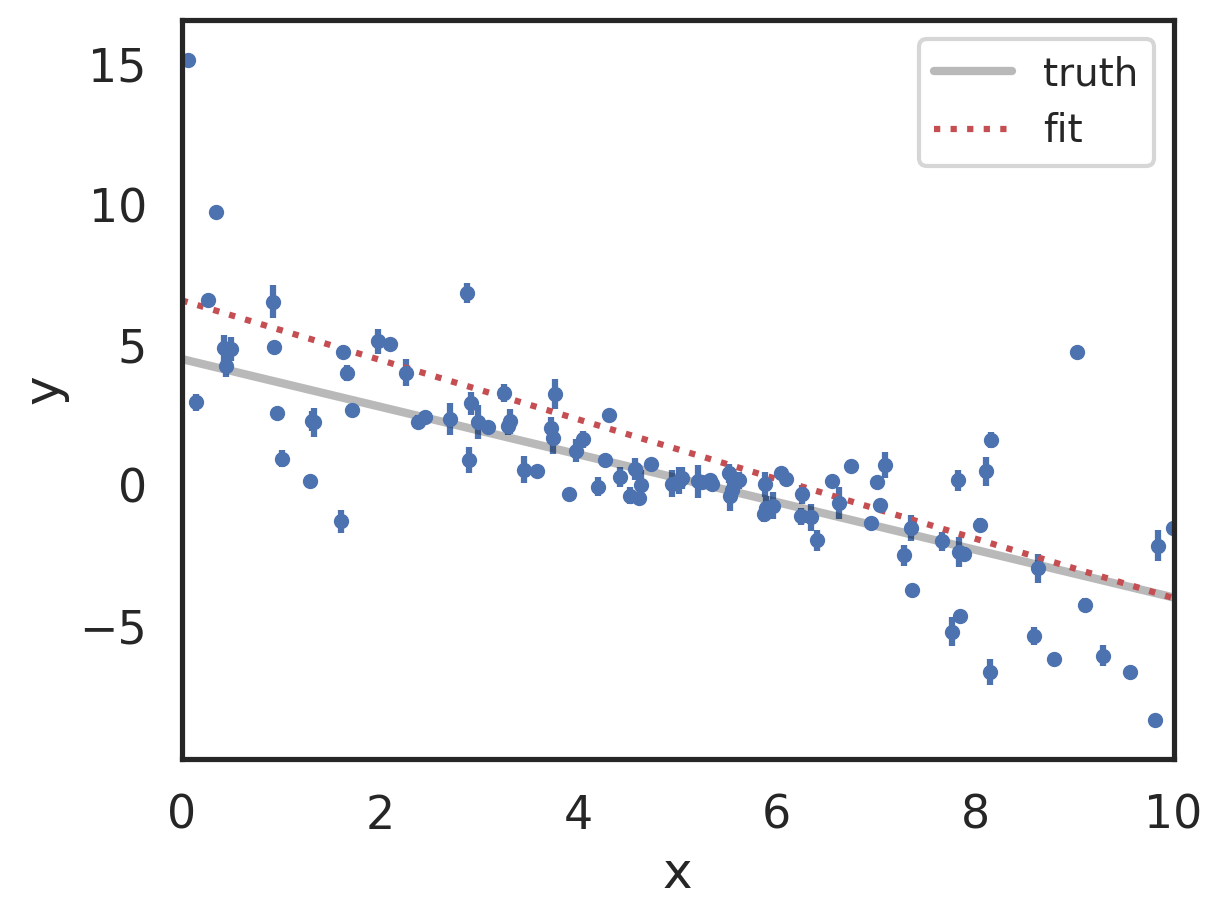

m = -1.0616 +/- inf (m_true = -0.85)
b = 6.591 +/- inf (b_true = 4.5)


In [9]:
def residual_function(params, x, y, yerr):
    m, b = params['m'].value, params['b'].value
    model = m*x + b
    return ((model - y)/yerr)**2

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
params = lmfit.Parameters()
params.add('m', value=p0[0])
params.add('b', value=p0[1])
results = lmfit.minimizer.minimize(residual_function, params, args=(x, y, yerr)
                                   , method='lbfgsb')

m_pred, b_pred = results.params['m'].value, results.params['b'].value
m_std, b_std = results.params['m'].stderr, results.params['b'].stderr
if m_std is None and b_std is None:
    m_std = b_std = np.inf

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".b", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":r", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

m_stimed.append(m_pred)
b_stimed.append(b_pred)
m_std_max.append(m_std)
m_std_min.append(m_std)
b_std_max.append(b_std)
b_std_min.append(b_std)
method.append("lmfit")

# **iminuit**

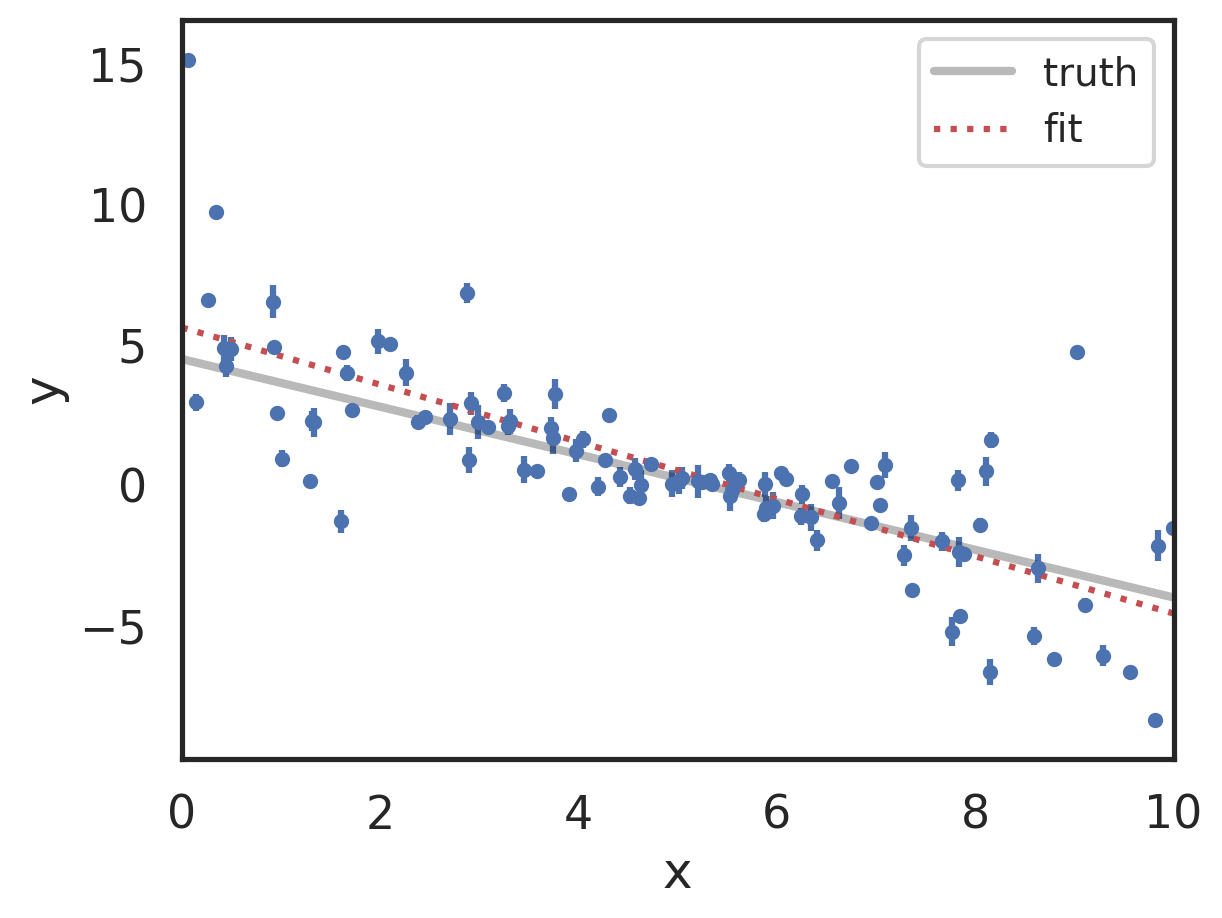

Hesse
m = -1.0198 +/- 0.0088 (m_true = -0.85)
b = 5.627 +/- 0.050 (b_true = 4.5)


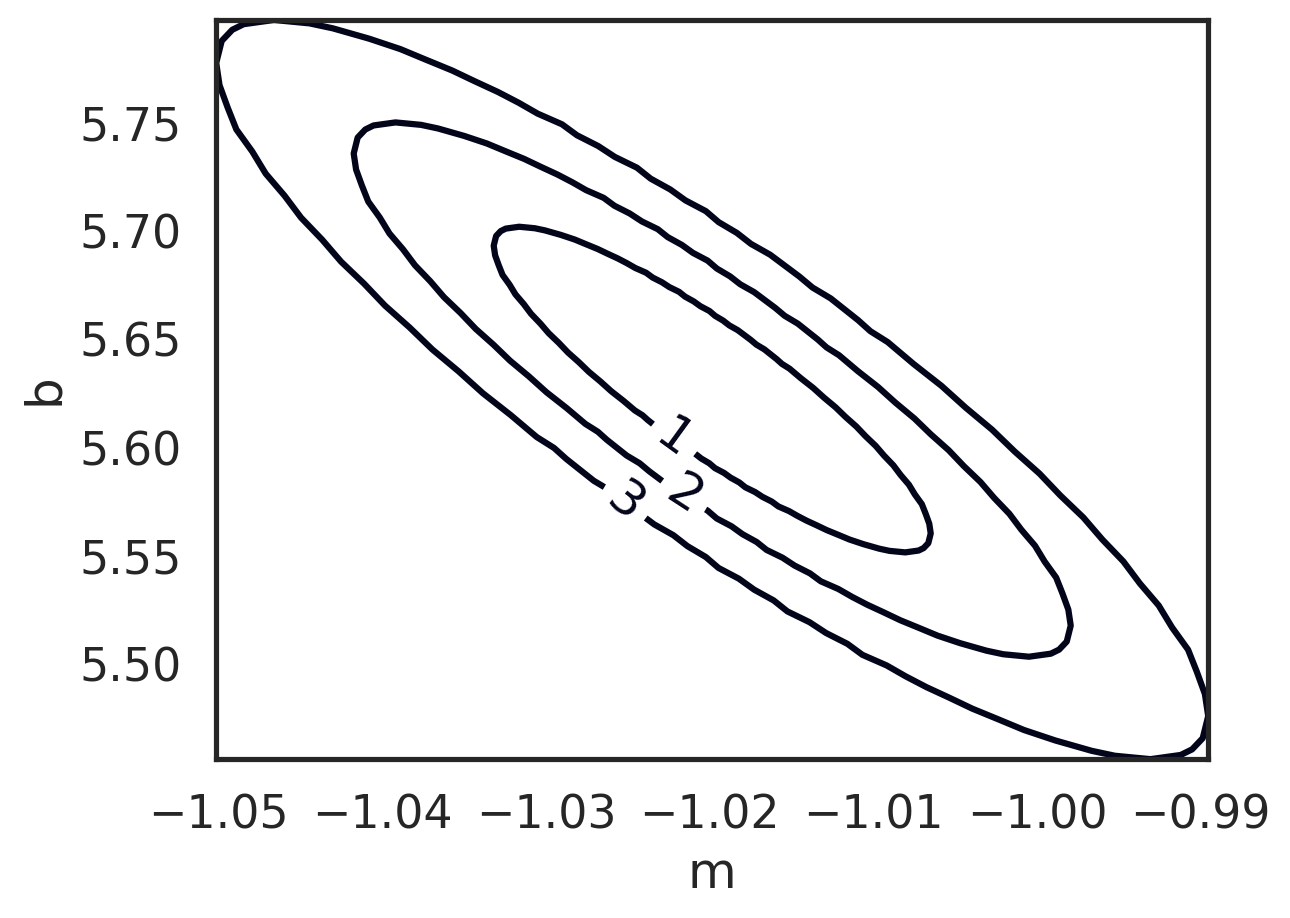

In [10]:
from iminuit import Minuit

def line(m, b, x, y):
    return m*x + b

def residual_function(m, b):
    #b, m = theta
    model = line(m, b, x, y)
    return np.sum(((model - y)/yerr)**2)

minu = Minuit(residual_function, m=1, b=1)

minu.migrad()  # run optimiser
minu.hesse()   # run covariance estimator
minu.minos()  # run minos estimator

m_pred, b_pred = minu.values

#.values()
m_std, b_std = minu.errors
#.values()
#m_std_max, b_std_max, m_std_min, b_std_min = minu.merrors.values()

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".b", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":r", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print('Hesse')
print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')
#print('Minos')
#print(f'm = {m_pred:.4f} +/- ({m_std_min:.4f}, {m_std_max:.4f}) (m_true = {m_true})')
#print(f'b = {b_pred:.3f} +/- ({b_std_min:.3f}, {b_std_max:.3f}) (b_true = {b_true})')

minu.draw_mncontour('m', 'b', cl=3)
minu.draw_mncontour('m', 'b', cl=2)
minu.draw_mncontour('m', 'b', cl=1)

m_stimed.append(m_pred)
b_stimed.append(b_pred)
m_std_max.append(m_std)
m_std_min.append(m_std)
b_std_max.append(b_std)
b_std_min.append(b_std)
method.append("minuit")

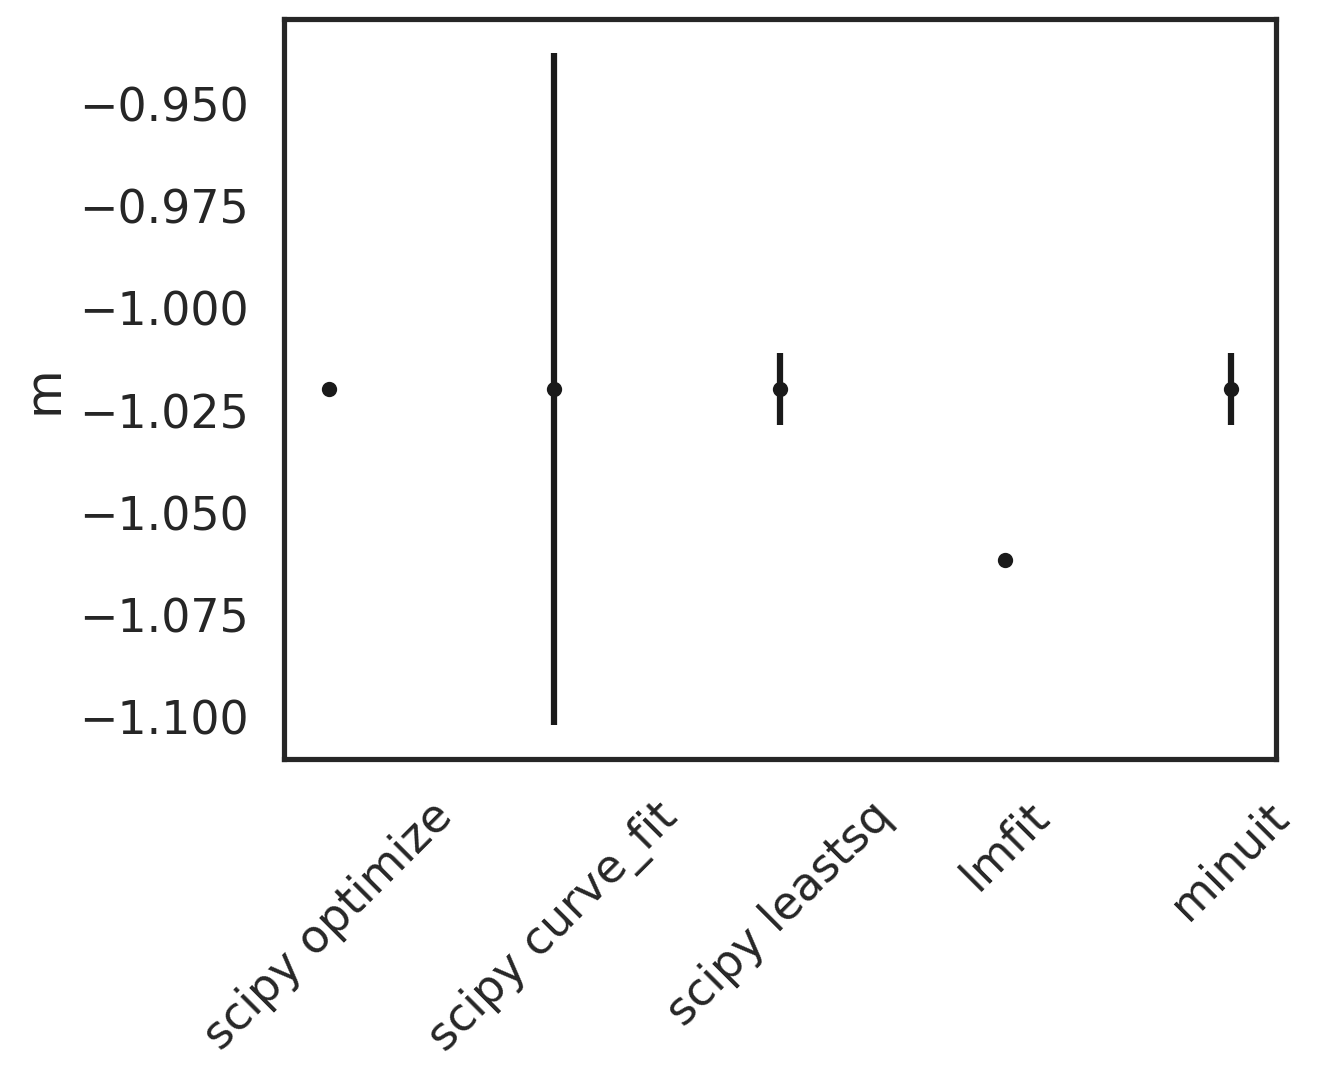

In [11]:
plt.errorbar(method,m_stimed, yerr=m_std_max, fmt='.k');
plt.xticks(method, method,rotation=45)
plt.ylabel('m')
plt.show()